# Landmark Augmentation

Increase landmark data by simulating variations found in real videos we don't have.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Augmentation Variation

## Mirroring (Horizontal Flip)
**Imitation**: This simulates scenarios involving left-handed and right-handed individuals.<br>
**How It Helps**:
*   Balances the dataset by effectively doubling the diversity of signs.
*   Helps the model learn symmetry in gestures, reducing bias towards one-handedness.

**Implementation:** Negate the x coordinates.

In [2]:
def mirror_landmarks(landmarks):
    mirrored = landmarks.copy()
    mirrored[:, 0] = -mirrored[:, 0]  # Flip X-axis
    return mirrored

## Rotation
**Imitation:** Models slight changes in camera angle or body posture.

**How It Helps:**
* Makes the model robust to minor misalignments during video capture.
* Prepares the model for non-perfect frontal views of gestures.

**Implementation:** Apply a 2D rotation transformation to landmarks.

In [3]:
def rotate_landmarks(landmarks, angle_deg=10):
    angle_rad = np.radians(angle_deg)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    return landmarks[:, :2] @ rotation_matrix.T  # Apply rotation on X-Y plane only

## Adding Noise (Jitter)
**Imitation:** Models real-world variations or inaccuracies in landmark detection.

**How It Helps:**
* Improves robustness to noisy data or detection errors during preprocessing.
* Encourages the model to learn key patterns, not rely on overly precise coordinates.

**Implementation:** Add random small values to the coordinates.

In [4]:
def add_noise(landmarks, noise_std=0.01):
    noisy = landmarks.copy()
    noise = np.random.normal(0, noise_std, landmarks.shape)  # Add noise to all coordinates (X, Y, Z)
    noisy += noise
    return noisy

# Augmentation

Instead of implementing the same augmentation for each video, randomness is used for every type of augmentation. This imitates the random quality of videos in real situations.

In [15]:
def augment_landmarks(landmarks):
    # Determine augmentations parameter and chance
    # mirror = random.random() < 0.5
    angle = random.uniform(-10, 10) if random.random() < 0.7 else 0
    noise_std = 0.01

    augmented_frames = []
    for frame in landmarks:
        augmented = frame.copy()

        # Uniformly applied across all frames
        # if mirror:
        #     augmented = mirror_landmarks(augmented)
        if angle != 0:
          augmented[:, :2] = rotate_landmarks(augmented, angle_deg=angle)

        # Randomly applied across all frames
        if random.random() < 0.5:
          augmented = add_noise(augmented, noise_std=noise_std)

        augmented_frames.append(augmented)

    return np.array(augmented_frames)

In [16]:
# Set seed for consistency
# random.seed(66)
# np.random.seed(66)

# Load landmarks
landmarks = np.load("/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train/adik/1.npy")

# Apply augmentation consistently across all frames of the video
augmented_landmarks_all = augment_landmarks(landmarks)

# Visualization

In [17]:
# Function to plot 2D landmarks for a single frame
def plot_landmarks_2d(landmarks, title="Landmarks", label='Original'):
    plt.scatter(landmarks[:, 0], landmarks[:, 1], label=label)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)

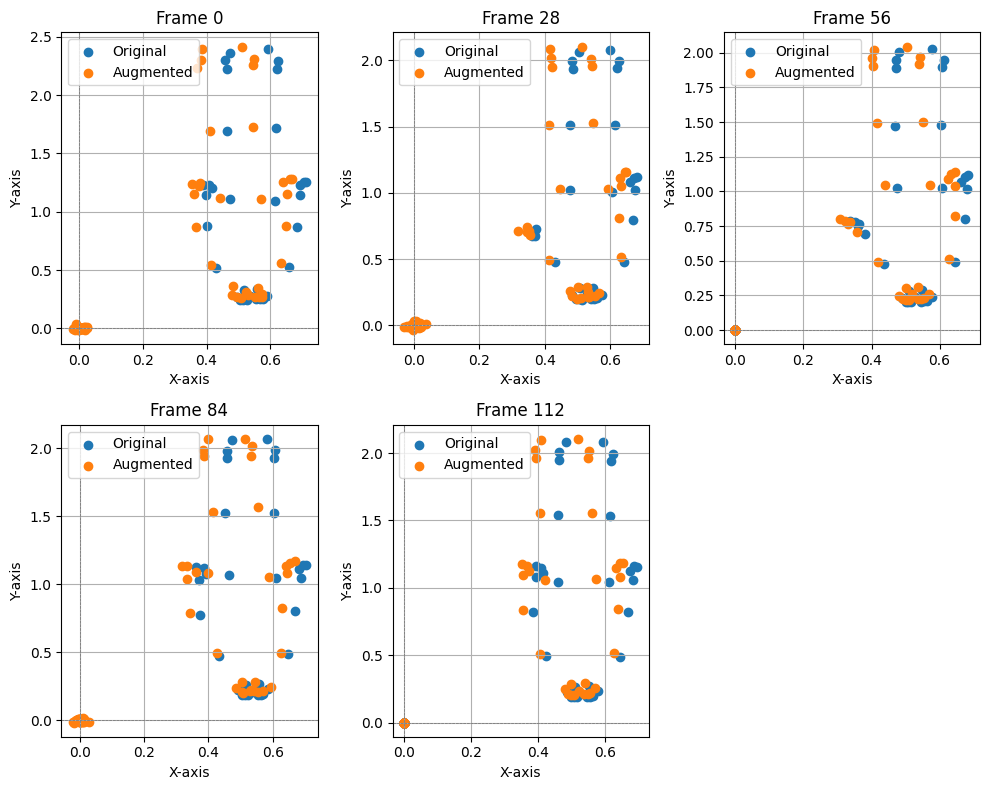

In [18]:
# Visualize a subset of frames
subset_indices = np.linspace(0, len(landmarks) - 1, 5, dtype=int)  # Choose 5 evenly spaced frames
plt.figure(figsize=(10, 8))
for i, idx in enumerate(subset_indices, start=1):
    plt.subplot(2, 3, i)
    plot_landmarks_2d(landmarks[idx], title=f"Original Frame {idx}", label="Original")
    plot_landmarks_2d(augmented_landmarks_all[idx], title=f"Frame {idx}", label="Augmented")

plt.tight_layout()
plt.show()

#Augment landmark 3 times and save

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train'
SAVE_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train'

os.makedirs(SAVE_DIR, exist_ok=True)

for word in os.listdir(DATA_DIR):
    word_dir = os.path.join(DATA_DIR, word)
    save_word_dir = os.path.join(SAVE_DIR, word)
    os.makedirs(save_word_dir, exist_ok=True)
    print("Processing", word, "Folder")
    for landmark_file in os.listdir(word_dir):
        base_name, ext = os.path.splitext(landmark_file)

        for i in range(3): # Loop 3 times for each video
            save_path = os.path.join(save_word_dir, f"{base_name}_aug_{i}{ext}")

            # Skip if the keypoints file already exists
            if os.path.exists(save_path):
                continue

            # print(f"Processing {word}/{landmark_file}, augmentation {i+1}/3")
            landmarks = np.load(os.path.join(word_dir, landmark_file))
            augmented_landmarks_all = augment_landmarks(landmarks)
            np.save(save_path, augmented_landmarks_all)  # Save as .npy

Processing buka Folder
Processing buruk Folder
Processing dengar Folder
Processing adik Folder
Processing nama Folder
Processing senyum Folder
Processing panggil Folder
Processing kucing Folder
Processing keluarga Folder
Processing ibu Folder
Processing marah Folder
Processing haus Folder
Processing selamat Folder
Processing gembira Folder
Processing teman Folder
Processing kertas Folder
Processing guru Folder
Processing jalan Folder
Processing makan Folder
Processing lihat Folder
Processing maaf Folder
Processing anak Folder
Processing orang Folder
Processing main Folder
Processing lapar Folder
Processing sedikit Folder
Processing rumah Folder
Processing besar Folder
Processing tidur Folder
Processing minum Folder


## Note for Potential Future Preprocessing Improvement:


*   Delete unecessary keypoint, like waist and below (pose 23-32)
*   Reimplement mirror for left-handed
* Implement interpolation for undetected hand, or model mask
* Pose+Hand instead of Holistic
* Parameter Tuning



# Data Merging

Merge all landmark npy into 1 for faster data loading time.

In [ ]:
def merge_npy_files(parent_folder, output_folder, output_file_name):
    # Initialize a list for merged data
    merged_data = []

    # Iterate through each label folder in the parent folder
    for label in os.listdir(parent_folder):
        label_folder = os.path.join(parent_folder, label)

        # Check if it's a folder
        if os.path.isdir(label_folder):
            # Iterate through each npy file in the label folder
            for file in os.listdir(label_folder):
                if file.endswith('.npy'):
                    file_path = os.path.join(label_folder, file)
                    data = np.load(file_path)  # Load the npy file
                    # Append a dictionary of data and label
                    merged_data.append({'data': data, 'label': label, 'file_name':file})

    # Save the merged data
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

    np.save(os.path.join(output_folder, output_file_name), merged_data)

    print("Merged data saved successfully!")

In [ ]:
parent_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train_augmented'
output_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks'
output_file_name = 'train_augmented.npy'
merge_npy_files(parent_folder, output_folder, output_file_name)


Merged data saved successfully!


In [ ]:
parent_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/test'
output_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks'
output_file_name = 'test.npy'
merge_npy_files(parent_folder, output_folder, output_file_name)

Merged data saved successfully!


In [ ]:
parent_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train'
output_folder = '/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks'
output_file_name = 'train.npy'
merge_npy_files(parent_folder, output_folder, output_file_name)

Merged data saved successfully!


# Load Data

In [ ]:
train_data = np.load('/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train.npy', allow_pickle=True)
train_data_aug = np.load('/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/train_augmented.npy', allow_pickle=True)

train_data = np.concatenate((train_data, train_data_aug), axis=0)
train_data.shape

(852,)

In [ ]:
print(train_data[0]['file_name'])
print(train_data[0]['label'])
print(train_data[0]['data'].shape)

louis_3.npy
buka
(113, 75, 3)


852 = 213 original + 639 augmented <br>
'file name' metadata could be useful for filtering

In [ ]:
X_train = [item['data'] for item in train_data]
y_train = [item['label'] for item in train_data]

# # Convert to NumPy arrays if needed
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (852, 113, 75, 3)
Shape of y_train: (852,)


In [ ]:
test_data = np.load('/content/drive/MyDrive/Omdena/sign_language_recognition/sign-landmark-dataset/final_landmarks/test.npy', allow_pickle=True)

# Extract features (X) and labels (y)
X_test = [item['data'] for item in test_data]
y_test = [item['label'] for item in test_data]

# Convert to NumPy arrays if needed
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (54, 113, 75, 3)
Shape of y_test: (54,)


In [ ]:
!pip install -q dagshub

from dagshub.notebook import save_notebook

save_notebook(repo="Omdena/JakartaIndonesia_SignLanguageTranslation", path="preprocessing", branch="kenji")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.2/252.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.4 MB/s eta 0:00:00
